<a href="https://colab.research.google.com/github/arindamkeswani/RePlicate/blob/main/RePlicate_(HPC_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Observations and assumptions so far:
1. Since an online plag checker would work on a cloud platform, we abandoned local testing in favour of a platform like Colab, as that would give results that are more realistic
2. Major tests done include comparing the execution time taken by:
  1. Serial implementation (for base time)
  2. Multiprocessing library (for base data-parallelism time)
  3. Numba library (for potential in-built optimum time)
  4. If time permits, other libraries such as CUDA will be considered for implementation

3. Other libraries, such as iparallel are performing worse than expected, and worse than serial implementation, so they were left out of the final analysis
4. Text files will be fed as input to the program (to be serially or manually converted beforehand since this project focusses of parallel plagiarism, detection, not conversion)

5. Final output will consist of two parts from the perspective of:
 1. Product: Dataframe/spreadsheet type structure, showing level of plagiarism between files
 2. Reasearch: A time-based comparison between the aforementioned methodologies.

 Original outcome expected data parallelism to perform better, but that is not the case, hence a black implemetation had to be adopted for successful completion.


---

Implementation:
1. First part involves building the plag-checker and applying the various devised methodologies.
2. The next step is building a PDF-to-text converter. The goal is to build a simple converter but if time permits, it will be implemented in parallel. 
3. The aim of the project is to create the first two modules. Future implementation will involve integrating the two modules together.

In [1]:
from google.colab import files 
uploaded = files.upload()

Saving fatma.txt to fatma.txt
Saving john.txt to john.txt
Saving juma.txt to juma.txt


In [55]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time
import pandas as pd
from numba import jit
from numba import njit
from numba.typed import List

In [56]:
student_files = [doc for doc in os.listdir() if doc.endswith('.txt')] #store all text files
student_notes =[open(File).read() for File in  student_files] #stores all lines of all files

In [57]:
vectorize = lambda Text: TfidfVectorizer().fit_transform(Text).toarray()  #to vectorize the words of text files
# similarity = lambda doc1, doc2: cosine_similarity([doc1, doc2]) #to store similarity of two documents

In [58]:
vectors = vectorize(student_notes) #store vectorized values
s_vectors = list(zip(student_files, vectors)) #store it with file names
# plagiarism_results = set() #to store results in a set
plagiarism_results =[]
# s_vectors

In [121]:
def similarity(doc1, doc2):
  return cosine_similarity([doc1, doc2])

In [129]:
def check_plagiarism(s_vectors_partial):
    # similarity = lambda doc1, doc2: cosine_similarity([doc1, doc2]) #to store similarity of two documents
    plagiarism_results =[]
    print("Starting process...")
    global s_vectors
    for student_a, text_vector_a in s_vectors_partial:  #traverse through students and their vectors (for first document)
        # print(f"Started testing:{student_a}")
        print("Started testing:",student_a)
        new_vectors = s_vectors.copy() 
        
        # current_index = new_vectors.index((student_a, text_vector_a))
        # del new_vectors[current_index]
        

        for student_b , text_vector_b in new_vectors: #traverse through students and their vectors (for second document)
            # print(f"Testing {student_a} against {student_b}")
            print("Testing",student_a,"against",student_b)
            # sim_score = similarity(text_vector_a, text_vector_b)[0][1] #calculate similarity of both documents
            sim_score = cosine_similarity([text_vector_a, text_vector_b])[0][1]
            # student_pair = sorted((student_a, student_b)) 
            student_pair = (student_a, student_b) 
            # score = (student_pair[0], student_pair[1],sim_score)
            score = [student_pair[0], student_pair[1],sim_score]
            # plagiarism_results.add(score) #add score with file names into the set
            plagiarism_results.append(score)
            print("Finished testing",student_a,"against",student_b)
        print()
    return plagiarism_results  
    # return createTable(plagiarism_results)

def createTable(ans):
    df=pd.DataFrame(np.zeros((len(student_files),len(student_files))),index=student_files,columns=student_files)

    for data in ans:
      for rowName in range(len(student_files)):
        if df.index[rowName]==data[0]:
          r=rowName
          for colName in range(len(student_files)):
            if df.index[colName]==data[1]:
              c=colName

              df.iloc[r,c] = data[2]
    return df

In [157]:
#Serial
%%time
start=time.time()
ans=check_plagiarism(s_vectors)
# df=createTable(ans)

end=time.time()
print()
print("Time taken:", end-start)

Starting process...
Started testing: juma.txt
Testing juma.txt against juma.txt
Finished testing juma.txt against juma.txt
Testing juma.txt against fatma.txt
Finished testing juma.txt against fatma.txt
Testing juma.txt against john.txt
Finished testing juma.txt against john.txt

Started testing: fatma.txt
Testing fatma.txt against juma.txt
Finished testing fatma.txt against juma.txt
Testing fatma.txt against fatma.txt
Finished testing fatma.txt against fatma.txt
Testing fatma.txt against john.txt
Finished testing fatma.txt against john.txt

Started testing: john.txt
Testing john.txt against juma.txt
Finished testing john.txt against juma.txt
Testing john.txt against fatma.txt
Finished testing john.txt against fatma.txt
Testing john.txt against john.txt
Finished testing john.txt against john.txt


Time taken: 0.02337789535522461
CPU times: user 20.4 ms, sys: 1.24 ms, total: 21.6 ms
Wall time: 23.5 ms


In [131]:
df

,juma.txt,fatma.txt,john.txt
juma.txt,1.000000,0.186434,0.546597
fatma.txt,0.186434,1.000000,0.148069
john.txt,0.546597,0.148069,1.000000




---

Parallel [Manual] approach

Ways to achieve data parallelism:
1. Divide s_vectors in parts (more likely)
2. Divide s_vectors[0][1] in parts (potential)

In [155]:
#Parallel [Manual] Part 1
%%time
start=time.time()
ans=check_plagiarism(s_vectors[:len(s_vectors)//2])

# for data in ans:
#     print(data)
# print(createTable(ans))
end=time.time()
print()
print("Time taken:", end-start)

Starting process...
Started testing: juma.txt
Testing juma.txt against juma.txt
Finished testing juma.txt against juma.txt
Testing juma.txt against fatma.txt
Finished testing juma.txt against fatma.txt
Testing juma.txt against john.txt
Finished testing juma.txt against john.txt


Time taken: 0.0019218921661376953
CPU times: user 2.13 ms, sys: 0 ns, total: 2.13 ms
Wall time: 1.99 ms


In [156]:
#Parallel [Manual] Part 2
%%time
start=time.time()
ans=check_plagiarism(s_vectors[len(s_vectors)//2:])

# for data in ans:
#     print(data)
# print(createTable(ans))
end=time.time()
print()
print("Time taken:", end-start)

Starting process...
Started testing: fatma.txt
Testing fatma.txt against juma.txt
Finished testing fatma.txt against juma.txt
Testing fatma.txt against fatma.txt
Finished testing fatma.txt against fatma.txt
Testing fatma.txt against john.txt
Finished testing fatma.txt against john.txt

Started testing: john.txt
Testing john.txt against juma.txt
Finished testing john.txt against juma.txt
Testing john.txt against fatma.txt
Finished testing john.txt against fatma.txt
Testing john.txt against john.txt
Finished testing john.txt against john.txt


Time taken: 0.004107475280761719
CPU times: user 3.11 ms, sys: 2.12 ms, total: 5.23 ms
Wall time: 4.19 ms




---





---

Multiprocessing approach

In [ ]:
s_vectors[:len(s_vectors)//2]

In [162]:
#Multiprocessing approach
%%time
import multiprocessing
import os

# def worker1(func1): 
#   func1(m)
  

start=time.time()

pool = multiprocessing.Pool(processes=2) 



l1 = s_vectors[:len(s_vectors)//2]
l2 = s_vectors[len(s_vectors)//2:]

start=time.time()

result = pool.map(check_plagiarism, [l1,l2])

for i in result:
  print(i)

# print(createTable(result))
# print(result)

end=time.time()

# ty.append("Multiprocessing [50000 elements]")
# t.append(end-start)

print("Time taken: ",end-start)

Starting process...
Started testing: juma.txt
Starting process...
Testing juma.txt against juma.txt
Started testing: fatma.txt
Finished testing juma.txt against juma.txt
Testing fatma.txt against juma.txt
Testing juma.txt against fatma.txt
Finished testing juma.txt against fatma.txt
Finished testing fatma.txt against juma.txt
Testing juma.txt against john.txt
Testing fatma.txt against fatma.txt
Finished testing fatma.txt against fatma.txt
Finished testing juma.txt against john.txt
Testing fatma.txt against john.txt

Finished testing fatma.txt against john.txt

Started testing: john.txt
Testing john.txt against juma.txt
Finished testing john.txt against juma.txt
Testing john.txt against fatma.txt
Finished testing john.txt against fatma.txt
Testing john.txt against john.txt
Finished testing john.txt against john.txt

[['juma.txt', 'juma.txt', 1.0000000000000004], ['juma.txt', 'fatma.txt', 0.18643448370323362], ['juma.txt', 'john.txt', 0.5465972177348937]]
[['fatma.txt', 'juma.txt', 0.186



---

Numba approach

In [135]:
#Numba approach
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [149]:
%%time
start=time.time()
# try:

num_res= jit(parallel=True)(check_plagiarism)


end=time.time()


CPU times: user 296 µs, sys: 0 ns, total: 296 µs
Wall time: 303 µs


In [151]:
%%time
a=num_res(s_vectors)

Starting process...
Started testing: juma.txt
Testing juma.txt against juma.txt
Finished testing juma.txt against juma.txt
Testing juma.txt against fatma.txt
Finished testing juma.txt against fatma.txt
Testing juma.txt against john.txt
Finished testing juma.txt against john.txt

Started testing: fatma.txt
Testing fatma.txt against juma.txt
Finished testing fatma.txt against juma.txt
Testing fatma.txt against fatma.txt
Finished testing fatma.txt against fatma.txt
Testing fatma.txt against john.txt
Finished testing fatma.txt against john.txt

Started testing: john.txt
Testing john.txt against juma.txt
Finished testing john.txt against juma.txt
Testing john.txt against fatma.txt
Finished testing john.txt against fatma.txt
Testing john.txt against john.txt
Finished testing john.txt against john.txt

CPU times: user 3.57 ms, sys: 968 µs, total: 4.54 ms
Wall time: 4.22 ms


In [106]:
#Convert set into
print("Time taken: ", end-start)

Time taken:  0.6218178272247314


In [145]:
df2=createTable(a)
df2

,juma.txt,fatma.txt,john.txt
juma.txt,1.000000,0.186434,0.546597
fatma.txt,0.186434,1.000000,0.148069
john.txt,0.546597,0.148069,1.000000




---

Results

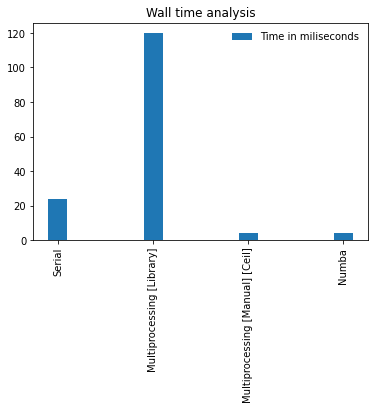

In [164]:
import matplotlib.pyplot as plt
import numpy as np

t=[23.5, 120, 4.19 , 4.22]
ty=["Serial", "Multiprocessing [Library]", "Multiprocessing [Manual] [Ceil]" , "Numba"]
nodes= np.arange(len(t))

plt.bar(nodes,t,width=0.2, align='center' ,label='Time in miliseconds')

plt.title("Wall time analysis")

plt.xticks(nodes,ty,rotation=90)
plt.legend(loc='best', frameon=False)
plt.show()



---


Rough space

In [ ]:
for data in ans:
  for rowName in range(len(student_files)):
    if df.index[rowName]==data[0]:
      r=rowName
      for colName in range(len(student_files)):
        if df.index[colName]==data[1]:
          c=colName

          df.iloc[r,c] = data[2]
df

In [ ]:
df=pd.DataFrame(np.zeros((len(student_files),len(student_files))),index=student_files,columns=student_files)
df

In [ ]:
df2=pd.DataFrame(np.zeros((len(student_files),len(student_files))),index=student_files,columns=student_files)
df2

,juma.txt,fatma.txt,john.txt
juma.txt,0.0,0.0,0.0
fatma.txt,0.0,0.0,0.0
john.txt,0.0,0.0,0.0


In [ ]:
for data in a:
  for rowName in range(len(student_files)):
    if df2.index[rowName]==data[0]:
      r=rowName
      for colName in range(len(student_files)):
        if df2.index[colName]==data[1]:
          c=colName

          df2.iloc[r,c] = data[2]
df2

,juma.txt,fatma.txt,john.txt
juma.txt,1.000000,0.186434,0.546597
fatma.txt,0.186434,1.000000,0.148069
john.txt,0.546597,0.148069,1.000000


In [108]:
from numba import jit


def sq(n):
  s=0
  for i in range(n):
    s+=i**2
  print(s)


In [109]:
%%time
sq(100000)

333328333350000
CPU times: user 30.7 ms, sys: 0 ns, total: 30.7 ms
Wall time: 31.5 ms


In [111]:
from numba import jit

# @jit(nopython=True)
def sq2(n):
  s=0
  for i in range(n):
    s+=i**2
  print(s)


In [112]:
%%time
ans=jit(nopython=True)(sq2)

CPU times: user 238 µs, sys: 28 µs, total: 266 µs
Wall time: 270 µs


In [ ]:
%%time 
ans(100000)

333328333350000
CPU times: user 138 µs, sys: 4 µs, total: 142 µs
Wall time: 101 µs
